<a href="https://colab.research.google.com/github/yitao416/onlinePlots/blob/master/Financial_data1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q langchain openai

In [ ]:
import os
from getpass import getpass
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType
from langchain.agents import create_csv_agent

from langchain.agents.agent_toolkits import create_python_agent
from langchain.tools.python.tool import PythonREPLTool
from langchain.python import PythonREPL
import pandas as pd

# Interactions with tabular date

Two kinds of source data:
1. Structured dataset, such as csv file
2. Unstructured dataset, such as the text from parsing the pdf file.

## Structured dataset

The main idea is to use GPT to write queries to analyze the data. The query language can be Python or SQL. And then present the result merely rely on the query result. The benefit here is avoiding putting all datasets into the prompt.

Example dataset:

[Titanic test datast CSV file](https://drive.google.com/file/d/1VO09mVwb96oWC_-Cw0rfVTVMIS3pQ1Ew/view?usp=drive_link)

In [ ]:
url = 'https://drive.google.com/file/d/1VO09mVwb96oWC_-Cw0rfVTVMIS3pQ1Ew/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
df.to_csv("titanic.csv", index=False)

In [ ]:
## create langchain agent
agent = create_csv_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    "titanic.csv",
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

In [ ]:
print(agent.run("give me a summary of each column"))



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df.describe(include='all')"}`


        PassengerId    Survived      Pclass              Name   Sex  \
count    418.000000  418.000000  418.000000               418   418   
unique          NaN         NaN         NaN               418     2   
top             NaN         NaN         NaN  Kelly, Mr. James  male   
freq            NaN         NaN         NaN                 1   266   
mean    1100.500000    0.363636    2.265550               NaN   NaN   
std      120.810458    0.481622    0.841838               NaN   NaN   
min      892.000000    0.000000    1.000000               NaN   NaN   
25%      996.250000    0.000000    1.000000               NaN   NaN   
50%     1100.500000    0.000000    3.000000               NaN   NaN   
75%     1204.750000    1.000000    3.000000               NaN   NaN   
max     1309.000000    1.000000    3.000000               NaN   NaN   

               Age       SibS



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\n\n# Filter dataframe where age is less than or equal to 50\ndf_age_50 = df[df['Age'] <= 50]\n\n# Plot histogram\nplt.hist(df_age_50['Age'], bins=20, edgecolor='black')\nplt.title('Age Distribution (Age <= 50)')\nplt.xlabel('Age')\nplt.ylabel('Frequency')\nplt.show()"}`




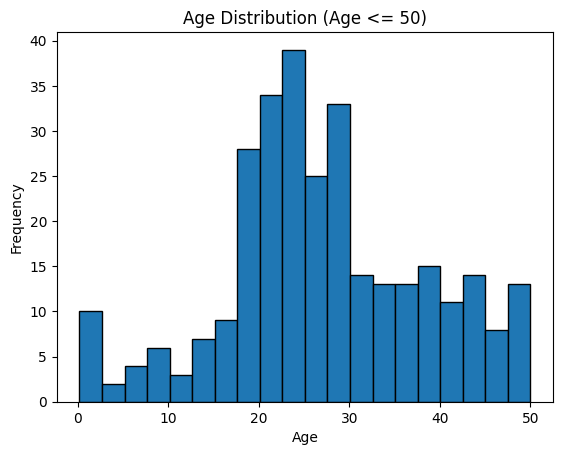

Here is the histogram of ages where age is less than or equal to 50. The x-axis represents the age and the y-axis represents the frequency of each age group.

> Finished chain.
Here is the histogram of ages where age is less than or equal to 50. The x-axis represents the age and the y-axis represents the frequency of each age group.


In [ ]:
print(agent.run("draw histogram of age, where age<=50"))

In [ ]:
# simple statistical testing
print(agent.run("for age variable, please perform the hypothesis testing on whether its mean equals to 30."))



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df['Age'].mean()"}`


30.272590361445783
Invoking: `python_repl_ast` with `{'query': "from scipy import stats\nstats.ttest_1samp(df['Age'].dropna(), 30)"}`
responded: {content}

TtestResult(statistic=0.35024042604606437, pvalue=0.7263810373750383, df=331)The result of the t-test gives us a t-statistic of approximately 0.35 and a p-value of approximately 0.73.

The p-value is much larger than the typical significance level of 0.05. Therefore, we do not reject the null hypothesis that the true mean age is 30. This suggests that the mean age of the passengers could indeed be 30.

> Finished chain.
The result of the t-test gives us a t-statistic of approximately 0.35 and a p-value of approximately 0.73.

The p-value is much larger than the typical significance level of 0.05. Therefore, we do not reject the null hypothesis that the true mean age is 30. This suggests that the mean age of the passengers coul


## Unstructured dataset

The table information is parsed from PDF, which it may contain unrelated information.

For example, the [PDF file](https://drive.google.com/file/d/1zAurh22WrdX7Q8b_-e61DCQDD9c9RHCH/view?usp=sharing).

By parsing this pdf, we can have its raw text format. To analyze this table, it's necessary to include it in the prompt. Therefore, there are some limits on how many unstructured dataset the GPT can handle with.

In [ ]:
## The text from the parsing of the pdf
text_table = """
Michigan Public Service Commission Case No.: U-20940
DTE Gas Company Exhibit: A-1
Historical Financial Metrics* - Financial Basis Schedule: A2
For the Historical Year Ended December 31, 2019 Witness: E. J. Solomon
Page 2 of 6
(a) (b) (c) (d) (e) (f)
Calendar Year
Line
No. Description 20152016201720182019
EBITDA Interest Coverage Ratio
19 Total EBIT                      253                      264                      305                      279                      316
20 Depreciation and Amortization                      102                      104                      122                      132                      142
21 Total EBITDA                      355                      368                      427                      411                      458
22 Interest Charges                        61                        60                        65                        70                        78
23 EBITDA Interest Coverage Ratio                       5.8                       6.1                       6.6                       5.9                       5.9
Funds Flow from Operations (FFO) Interest
Coverage Ratio
24 Net Income                      132                      138                      146                      149                      186
25 Depreciation and Amortization                      102                      104                      122                      132                      142
26 Deferred Income Tax                        72                        74                        46                        64                        54
27 AFUDC                         (1)                         (4)                         (5)                         (7)                         (1)
28 Other Major Recurring Non-Cash Items                       -                       -                       -
29 Interest Paid                        61                        60                        65                        70                        78
30 Subtotal                      366                      372                      374                      408                      459
31 Interest Charges                        61                        60                        65                        70                        78
32 FFO Interest Coverage Ratio                       6.0                       6.2                       5.8                       5.8                       5.9
Overall Fixed Charge Coverage Ratio
33 Net Income Available for Common $                   132 $                   138 $                   146 $                   149 $                   186
34 Interest Charges                        61                        60                        65                        70                        78
35 Subtotal Numerator                      193                      198                      211                      219                      264
36 Interest Charges                        61                        60                        65                        70                        78
37 Preferred Stock Dividends                       -                       -                       -                       -                       -
38 Subtotal Denominator                        61                        60                        65                        70                        78
39 Overall Fixed Charge Coverage Ratio                       3.2                       3.3                       3.2                       3.1                       3.4
"""

### We can use a plain GPT model to analyze.

In [ ]:
llm = ChatOpenAI(temperature=0, model="gpt-4")
prompt = "Please give a summary about the following table. " + text_table
print(llm.predict(prompt))

The table presents the historical financial metrics of DTE Gas Company for the years 2015 to 2019. The metrics include EBITDA Interest Coverage Ratio, Funds Flow from Operations (FFO) Interest Coverage Ratio, and Overall Fixed Charge Coverage Ratio. 

For the EBITDA Interest Coverage Ratio, the Total EBITDA increased from 355 in 2015 to 458 in 2019. The EBITDA Interest Coverage Ratio remained relatively stable, ranging from 5.8 to 6.6 over the five years.

For the FFO Interest Coverage Ratio, the subtotal increased from 366 in 2015 to 459 in 2019. The FFO Interest Coverage Ratio also remained relatively stable, ranging from 5.8 to 6.2 over the five years.

For the Overall Fixed Charge Coverage Ratio, the subtotal numerator increased from 193 in 2015 to 264 in 2019. The Overall Fixed Charge Coverage Ratio ranged from 3.1 to 3.4 over the five years.


In [ ]:
## this task shows the gpt can understand the numbers correctly.
prompt = "Clean the table and convert it to csv format." + text_table
print(llm.predict(prompt))

"Line No.","Description","2015","2016","2017","2018","2019"
19,"Total EBIT",253,264,305,279,316
20,"Depreciation and Amortization",102,104,122,132,142
21,"Total EBITDA",355,368,427,411,458
22,"Interest Charges",61,60,65,70,78
23,"EBITDA Interest Coverage Ratio",5.8,6.1,6.6,5.9,5.9
24,"Net Income",132,138,146,149,186
25,"Depreciation and Amortization",102,104,122,132,142
26,"Deferred Income Tax",72,74,46,64,54
27,"AFUDC",-1,-4,-5,-7,-1
28,"Other Major Recurring Non-Cash Items",0,0,0,0,0
29,"Interest Paid",61,60,65,70,78
30,"Subtotal",366,372,374,408,459
31,"Interest Charges",61,60,65,70,78
32,"FFO Interest Coverage Ratio",6.0,6.2,5.8,5.8,5.9
33,"Net Income Available for Common",132,138,146,149,186
34,"Interest Charges",61,60,65,70,78
35,"Subtotal Numerator",193,198,211,219,264
36,"Interest Charges",61,60,65,70,78
37,"Preferred Stock Dividends",0,0,0,0,0
38,"Subtotal Denominator",61,60,65,70,78
39,"Overall Fixed Charge Coverage Ratio",3.2,3.3,3.2,3.1,3.4


In [ ]:
prompt = "Please tell me which year has the 2nd largest Total EBIT according this table." + text_table
print(llm.predict(prompt))

The year with the 2nd largest Total EBIT according to the table is 2017.


## Call a Python assistant for analysis and visualization

In [ ]:
agent_executor = create_python_agent(
    llm=ChatOpenAI(temperature=0.1, max_tokens=1000, model='gpt-4'),
    tool=PythonREPLTool(),
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
)

In [ ]:
prompt = "Please tell me which year has the 2nd largest Total EBIT according this table." + text_table
print(agent_executor.run(prompt))



> Entering new AgentExecutor chain...



Invoking: `Python_REPL` with `ebit_values = {2015: 253, 2016: 264, 2017: 305, 2018: 279, 2019: 316}
second_largest_year = sorted(ebit_values.items(), key=lambda x: x[1], reverse=True)[1][0]
print(second_largest_year)`


2017
The year with the 2nd largest Total EBIT according to the table is 2017.

> Finished chain.
The year with the 2nd largest Total EBIT according to the table is 2017.




> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `import matplotlib.pyplot as plt

years = [2015, 2016, 2017, 2018, 2019]

EBIT = [253, 264, 305, 279, 316]
Depreciation_and_Amortization = [102, 104, 122, 132, 142]
Total_EBITDA = [355, 368, 427, 411, 458]
Interest_Charges = [61, 60, 65, 70, 78]
EBITDA_Interest_Coverage_Ratio = [5.8, 6.1, 6.6, 5.9, 5.9]

Net_Income = [132, 138, 146, 149, 186]
Deferred_Income_Tax = [72, 74, 46, 64, 54]
AFUDC = [-1, -4, -5, -7, -1]
Interest_Paid = [61, 60, 65, 70, 78]
Subtotal = [366, 372, 374, 408, 459]
FFO_Interest_Coverage_Ratio = [6.0, 6.2, 5.8, 5.8, 5.9]

Net_Income_Available_for_Common = [132, 138, 146, 149, 186]
Subtotal_Numerator = [193, 198, 211, 219, 264]
Subtotal_Denominator = [61, 60, 65, 70, 78]
Overall_Fixed_Charge_Coverage_Ratio = [3.2, 3.3, 3.2, 3.1, 3.4]

plt.figure(figsize=(10, 6))

plt.plot(years, EBIT, label='EBIT')
plt.plot(years, Depreciation_and_Amortization, label='Depreciation and Amortization')
plt.plot(years,

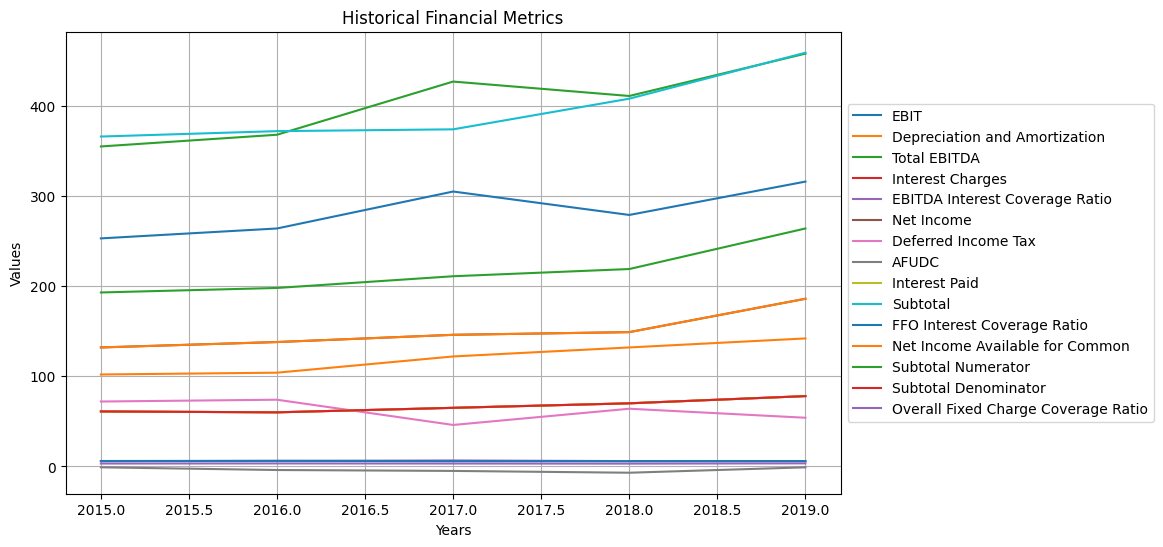

The plot shows the historical financial metrics for the years 2015 to 2019. The legend is placed outside the plot for better visibility. Each line represents a different financial metric, such as EBIT, Depreciation and Amortization, Total EBITDA, Interest Charges, EBITDA Interest Coverage Ratio, Net Income, Deferred Income Tax, AFUDC, Interest Paid, Subtotal, FFO Interest Coverage Ratio, Net Income Available for Common, Subtotal Numerator, Subtotal Denominator, and Overall Fixed Charge Coverage Ratio.

> Finished chain.


'The plot shows the historical financial metrics for the years 2015 to 2019. The legend is placed outside the plot for better visibility. Each line represents a different financial metric, such as EBIT, Depreciation and Amortization, Total EBITDA, Interest Charges, EBITDA Interest Coverage Ratio, Net Income, Deferred Income Tax, AFUDC, Interest Paid, Subtotal, FFO Interest Coverage Ratio, Net Income Available for Common, Subtotal Numerator, Subtotal Denominator, and Overall Fixed Charge Coverage Ratio.'

In [ ]:
prompt = "Plot items over the years according to this table. Keep the legend out." + text_table
agent_executor.run(prompt)



> Entering new AgentExecutor chain...

Invoking: `Python_REPL` with `import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
years = [2015, 2016, 2017, 2018, 2019]
data = {
    'EBITDA Interest Coverage Ratio': [5.8, 6.1, 6.6, 5.9, 5.9],
    'FFO Interest Coverage Ratio': [6.0, 6.2, 5.8, 5.8, 5.9],
    'Overall Fixed Charge Coverage Ratio': [3.2, 3.3, 3.2, 3.1, 3.4]
}
df = pd.DataFrame(data, index=years)

# Plot
sns.set()
plt.figure(figsize=(10, 6))
for column in df.columns:
    plt.plot(df.index, df[column], marker='o', label=column)
    for x, y in zip(df.index, df[column]):
        plt.text(x, y, str(y), color='black', fontsize=12, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Coverage Ratio Over the Years')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.grid(True)
plt.show()`




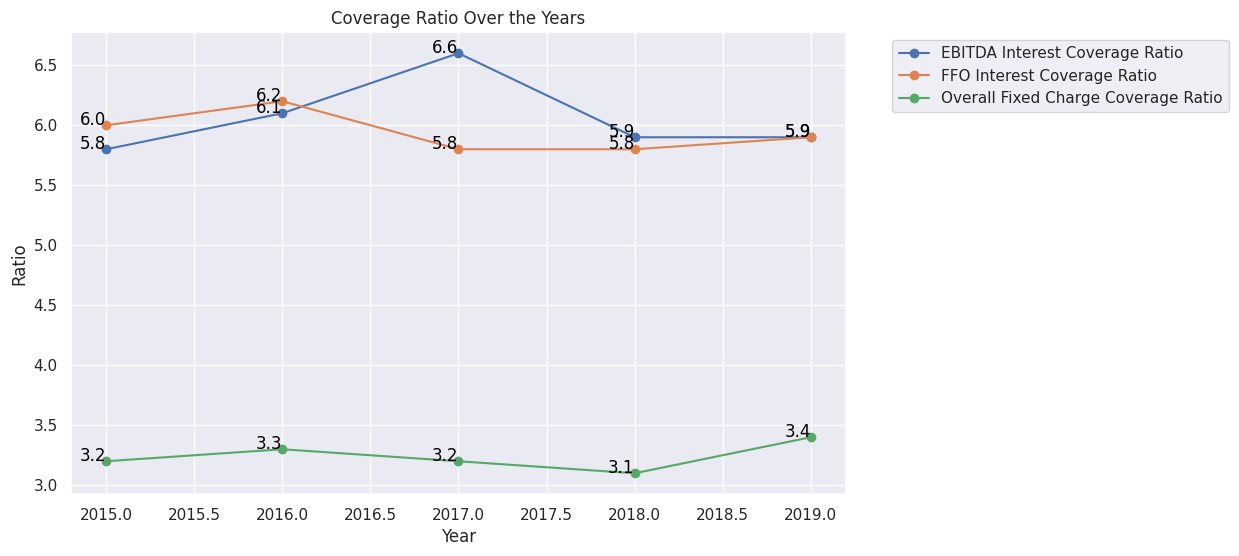

Here is the plot of 'Coverage Ratio' related items over the years according to the table. The legend is moved out of the plot for better visibility. Each point on the lines is annotated with its value. The plot is created with a seaborn theme.

> Finished chain.


"Here is the plot of 'Coverage Ratio' related items over the years according to the table. The legend is moved out of the plot for better visibility. Each point on the lines is annotated with its value. The plot is created with a seaborn theme."

In [ ]:
prompt = """Plot 'Coverage Ratio' related items over the years according to this table. Move the legend out.
Line plot with scatter. Annotate each point. Use seaborn theme.""" + text_table
agent_executor.run(prompt)